# **Analysis of decoding results**

## **Libraries**

In [1]:
#%pip install pandas matplotlib seaborn nltk sacrebleu

In [2]:
import os
import warnings

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import nltk
import sacrebleu

import constants

## **Directories**

In [3]:
RESULTS_FOLDER = constants.RESULTS_DATA_FOLDER
INSPECTED_FOLDER = constants.INSPECTED_DATA_FOLDER

DECODED_OUTPUTS_FILENAME = 'es_gn_decode_checkpoints-100.log' #'split_decode_checkpoint_100-80.log'#'first_decode_checkpoint_100-50.log'#
DECODED_OUTPUTS_FILEPATH = os.path.join(INSPECTED_FOLDER, DECODED_OUTPUTS_FILENAME)
REFERENCE_SOURCE_FILENAME = 'valid_es.txt.es' #'first_val_gn.txt'#
REFERENCE_SOURCE_FILEPATH = os.path.join(INSPECTED_FOLDER, REFERENCE_SOURCE_FILENAME)
REFERENCE_DESTINATION_FILENAME = 'valid_gn.txt.gn' #'first_val_es.txt'#
REFERENCE_DESTINATION_FILEPATH = os.path.join(INSPECTED_FOLDER, REFERENCE_DESTINATION_FILENAME)
FIRST_DECODING_RESULTS_FOLDER = os.path.join(RESULTS_FOLDER, 'first_decode_checkpoint_100-50')
CURRENT_RESULTS_FOLDER = os.path.join(FIRST_DECODING_RESULTS_FOLDER, DECODED_OUTPUTS_FILENAME.split('.')[0])

if not os.path.exists(FIRST_DECODING_RESULTS_FOLDER):
    os.makedirs(FIRST_DECODING_RESULTS_FOLDER)

if not os.path.exists(CURRENT_RESULTS_FOLDER):
    os.makedirs(CURRENT_RESULTS_FOLDER)

In [4]:
with open(REFERENCE_SOURCE_FILEPATH, 'r', encoding='utf-8') as f:
    reference_source_gn = f.readlines()

with open(REFERENCE_DESTINATION_FILEPATH, 'r', encoding='utf-8') as f:
    reference_destination_es = f.readlines()

with open(DECODED_OUTPUTS_FILEPATH, 'r', encoding='utf-8') as f:
    decoded_outputs = f.readlines()

## **Checking files**

In [5]:
print(f'Number of lines in reference source: {len(reference_source_gn)}')
print(f'Number of lines in reference destination: {len(reference_destination_es)}')
print(f'Number of lines in decoded outputs: {len(decoded_outputs)}')

Number of lines in reference source: 5310
Number of lines in reference destination: 5310
Number of lines in decoded outputs: 5309


There is a difference of 1 between the number of lines in the decoded outputs and the number of lines in the original inputs.

In [6]:
for idx, (elem_ref, elem_dest, decoded) in enumerate(zip(reference_source_gn, reference_destination_es, decoded_outputs)):
    if elem_ref.strip() == '':
        print(f'Empty line at index {idx} from reference source')

    if elem_dest.strip() == '':
        print(f'Empty line at index {idx} from reference destination')

    if decoded.strip() == '':
        print(f'Empty line at index {idx} from decoded outputs')

This extra line is not a problem, as the decoded file can output empty lines. However, it remains unclear why the length of the files are different.

## **Score analysis**

### **Examples of BLEU score**

In [7]:
def silence_warnings(func):
    def wrapper(*args, **kwargs):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            return func(*args, **kwargs)
    return wrapper

In [8]:
correct_reference = ['Today', 'is', 'a', 'new', 'day']
short_reference = ['Today']
wrong_reference = ['Yesterday', 'was', 'a', 'good', 'day']

translated = ['Today', 'is', 'a', 'new', 'day']

### **Classic BLEU**

In [9]:
@silence_warnings
def calculate_bleu(reference, translated, bleu_score_type='classic'):
    classic_bleu_function = lambda reference, translated: nltk.translate.bleu_score.sentence_bleu([reference], translated)
    chrf_function = lambda reference, translated: sacrebleu.corpus_chrf(translated, [reference]).score
    sacrebleu_function = lambda reference, translated: sacrebleu.corpus_bleu([' '.join(translated)], [[' '.join(reference)]]).score
    
    score_functions = {
        'classic': classic_bleu_function,
        'chrf': chrf_function,
        'sacrebleu': sacrebleu_function
    }

    bleu_score = score_functions[bleu_score_type](reference, translated)
    return bleu_score

In [10]:
def create_bleu_scores_df(references, translated, bleu_score_types):
    bleu_scores_df = {'reference': [], 'translation': [], 'metric': [], 'score': []}

    for reference, translation in zip(references, translated):
        for bleu_score_type in bleu_score_types:
            bleu_score = calculate_bleu(reference, translation, bleu_score_type=bleu_score_type)
            bleu_scores_df['reference'].append(' '.join(reference))
            bleu_scores_df['translation'].append(' '.join(translation))
            bleu_scores_df['metric'].append(bleu_score_type)
            bleu_scores_df['score'].append(bleu_score)

    return pd.DataFrame(bleu_scores_df)

#### **Test examples**

In [11]:
example_dfs = []

example_references = [correct_reference, short_reference, wrong_reference]
bleu_scores_example_df = create_bleu_scores_df(
    example_references, 
    [translated]*len(example_references), 
    bleu_score_types=['classic', 'chrf', 'sacrebleu']
)
example_dfs.append(bleu_scores_example_df)

example_dfs = pd.concat(example_dfs)
example_dfs.style.format({'score': '{:.5g}'})

,reference,translation,metric,score
0,Today is a new day,Today is a new day,classic,1
1,Today is a new day,Today is a new day,chrf,100
2,Today is a new day,Today is a new day,sacrebleu,100
3,Today,Today is a new day,classic,1.2183e-231
4,Today,Today is a new day,chrf,100
5,Today,Today is a new day,sacrebleu,10.682
6,Yesterday was a good day,Today is a new day,classic,1.4488e-231
7,Yesterday was a good day,Today is a new day,chrf,18.448
8,Yesterday was a good day,Today is a new day,sacrebleu,12.703


In [12]:
#calculate chrf score
def calculate_chrf(reference, translated):
    chrf_score = sacrebleu.corpus_chrf(translated, [reference]).score
    return chrf_score

reference = ['Today', 'is', 'a', 'ne', 'day']
translated = ['Today', 'is', 'a', 'new', 'day']

chrf_score = calculate_chrf(reference, translated)
print(f'CHRF score: {chrf_score}')

CHRF score: 99.24787442773054


### **BLEU score distribution**

In [13]:
tokenized_reference_destination_es = [reference.split() for reference in reference_destination_es]
tokenized_decoded_outputs = [decoded.split() for decoded in decoded_outputs]
bleu_scores_df = create_bleu_scores_df(
    tokenized_reference_destination_es,
    tokenized_decoded_outputs,
    bleu_score_types=['classic', 'chrf', 'sacrebleu']
)

In [14]:
save_path = os.path.join(CURRENT_RESULTS_FOLDER, 'bleu_scores.csv')
bleu_scores_df.to_csv(save_path, index=False)

In [15]:
for metric in bleu_scores_df['metric'].unique():
    print(f'Metric: {metric}')
    print(bleu_scores_df[bleu_scores_df['metric'] == metric].describe())
    print()

save_path = os.path.join(CURRENT_RESULTS_FOLDER, 'bleu_scores_summary.csv')
bleu_scores_df.groupby(['metric']).describe().to_csv(save_path)

Metric: classic
               score
count   5.309000e+03
mean    7.900733e-03
std     3.971146e-02
min     0.000000e+00
25%     0.000000e+00
50%    9.594503e-232
75%    3.229753e-155
max     6.548908e-01

Metric: chrf
             score
count  5309.000000
mean      8.835734
std      10.655344
min       0.000000
25%       3.830046
50%       5.117239
75%       8.623733
max     100.000000

Metric: sacrebleu
             score
count  5309.000000
mean      3.268224
std       5.128090
min       0.000000
25%       0.000000
50%       1.647914
75%       4.175416
max      59.460356



This does not align with the BLEU score returned by marian.

TODO: Sentences shorter than 4 words are not well-suited for BLEU scoring.

In [16]:
def plot_scores(ax, scores, titles, xlabel, save_path=None, color='blue'):
    sns.set_style('darkgrid')
    for idx, (score, title) in enumerate(zip(scores, titles)):
        current_ax = ax[idx] if len(scores) > 1 else ax
        sns.kdeplot(score, fill=True, ax=current_ax, color=color)
        current_ax.set(xlabel=xlabel, ylabel='Density', title=title)

    if save_path is not None:
        plt.savefig(save_path)
        sns.set_style('darkgrid')

In [17]:
def plot_thresholded_scores(scores, titles, xlabels, acceptance_thresholds, negligible_thresholds, save_path=None, colors=['blue']):
    non_negligible_scores = []
    acceptable_scores = []
    
    for score, acceptance_threshold, negligible_threshold in zip(scores, acceptance_thresholds, negligible_thresholds):
        non_negligible_scores.append([s for s in score if s > negligible_threshold])
        acceptable_scores.append([s for s in score if s > acceptance_threshold])

    plotted_scores = list(zip(scores, non_negligible_scores, acceptable_scores))

    nrows = len(scores)
    ncols = len(plotted_scores)

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 20))
    fig.suptitle(f'{" - ".join(xlabels)} scores', fontsize=20)
    for idx, (score, title, xlabel, color) in enumerate(zip(plotted_scores, titles, xlabels, colors)):
        current_ax = ax[idx] if nrows > 1 else ax
        plot_scores(current_ax, score, title, xlabel, color=color)
    if save_path is not None:
        plt.savefig(save_path)

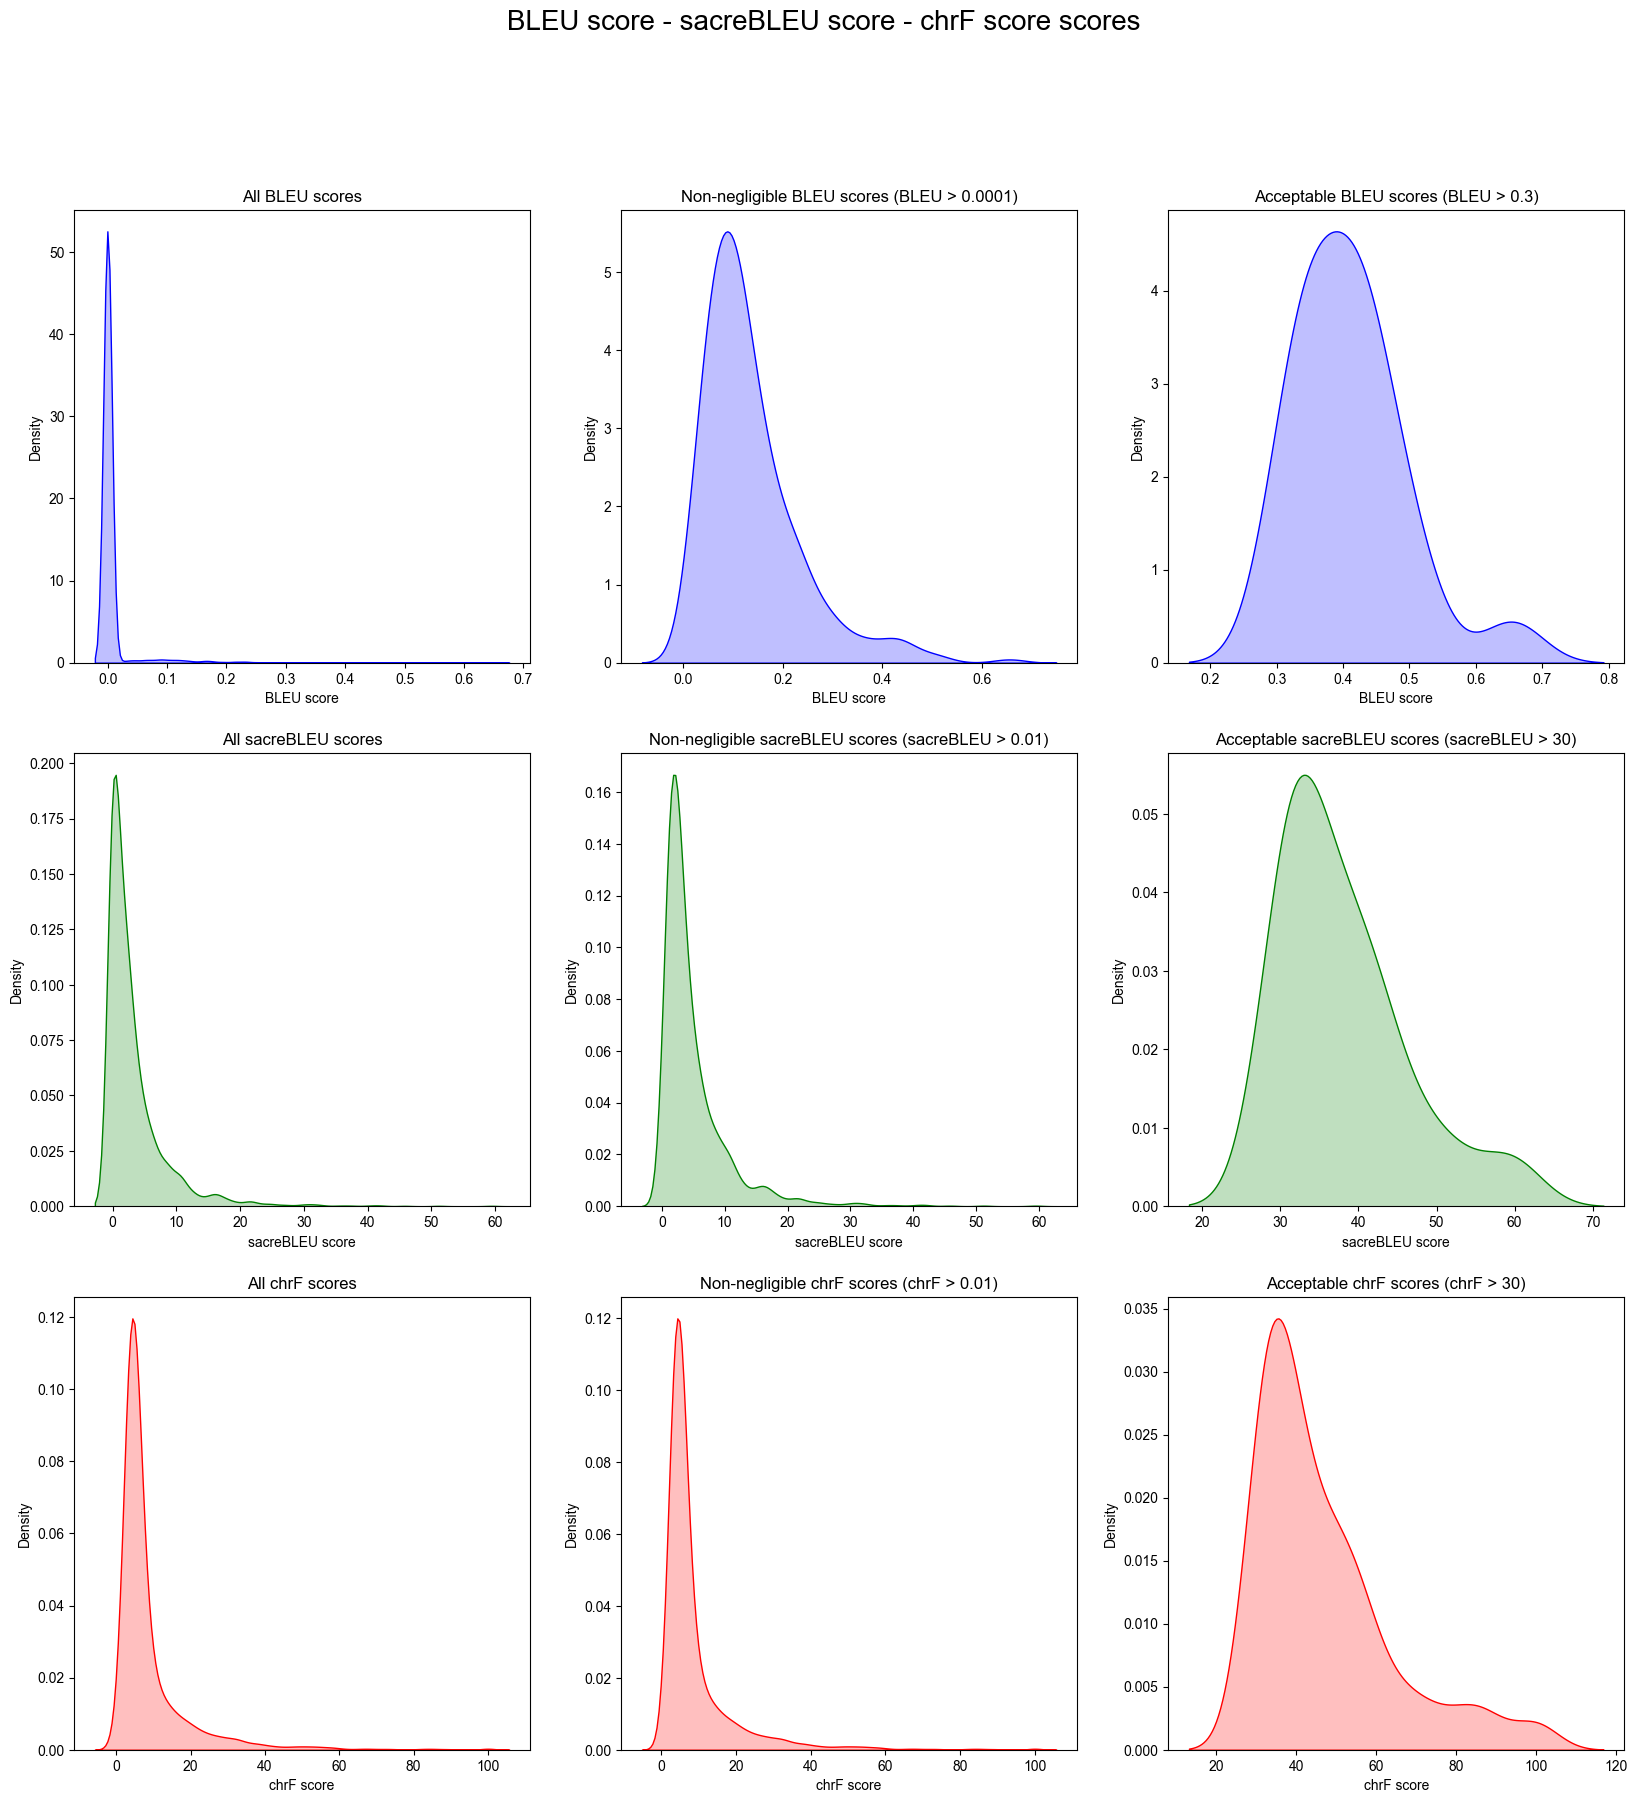

In [18]:
bleu_classic_scores = bleu_scores_df[bleu_scores_df['metric'] == 'classic']['score']
sacrebleu_scores    = bleu_scores_df[bleu_scores_df['metric'] == 'sacrebleu']['score']
chrf_scores         = bleu_scores_df[bleu_scores_df['metric'] == 'chrf']['score']
scores = [bleu_classic_scores, sacrebleu_scores, chrf_scores]

acceptance_thresholds = [0.3, 30, 30]
epsilons = [0.0001, 0.01, 0.01]
save_path = os.path.join(CURRENT_RESULTS_FOLDER, 'bleu_scores.png')

bleu_titles = ['All BLEU scores', f'Non-negligible BLEU scores (BLEU > {epsilons[0]})', f'Acceptable BLEU scores (BLEU > {acceptance_thresholds[0]})']
sacrebleu_titles = ['All sacreBLEU scores', f'Non-negligible sacreBLEU scores (sacreBLEU > {epsilons[1]})', f'Acceptable sacreBLEU scores (sacreBLEU > {acceptance_thresholds[1]})']
chrf_titles = ['All chrF scores', f'Non-negligible chrF scores (chrF > {epsilons[2]})', f'Acceptable chrF scores (chrF > {acceptance_thresholds[2]})']
titles = [bleu_titles, sacrebleu_titles, chrf_titles]
xlabels = ['BLEU score', 'sacreBLEU score', 'chrF score']
colors = ['blue', 'green', 'red']

plot_thresholded_scores(scores, titles, xlabels, acceptance_thresholds, epsilons, save_path=save_path, colors=colors)

### **Best BLEU scores**

In [19]:
def get_ordered_score_indexes(scores, best=True, limit=3):
    return sorted(range(len(scores)), key=lambda i: scores[i], reverse=best)[:limit]

def show_translations(indexes, reference_source, reference_destination, decoded_outputs, save_path=None):

    printed_messages = []
    for idx in indexes:
        reference_destination_tokens = set(reference_destination[idx].strip().split(' '))
        decoded_output_tokens = set(decoded_outputs[idx].strip().split(' '))
        overlapping_words = reference_destination_tokens.intersection(decoded_output_tokens)
        
        printed_message = [
            f'Index: {idx}',
            f'Reference source: {reference_source[idx][:-1]}',
            f'Reference destination: {reference_destination[idx][:-1]}',
            f'Decoded output: {decoded_outputs[idx]}',
            f'Reference destination tokens: {reference_destination_tokens}',
            f'Decoded output tokens: {decoded_output_tokens}',
            f'Overlapping words: {overlapping_words}',
            '------------------'
        ]
        printed_messages.append('\n'.join(printed_message))

    for message in printed_messages:
        print(message)

    if save_path is not None:
        with open(save_path, 'w', encoding='utf-8') as f:
            f.write('\n\n'.join(printed_messages))

In [20]:
best_indexes = get_ordered_score_indexes(list(bleu_classic_scores), best=True, limit=10)
save_dir = os.path.join(CURRENT_RESULTS_FOLDER, 'best_translations.txt')
show_translations(best_indexes, reference_source_gn, reference_destination_es, decoded_outputs, save_path=save_dir)

Index: 4875
Reference source: MINISTRA DE LA SPL DISERTÓ SOBRE EL GUARANÍ EN UN CONGRESO INTERNACIONAL.
Reference destination: SÃMBYHYHÁRA ALCARAZ OÑE'Ẽ GUARANI REHE PETEĨ AMANDAJE GUASÚPE, ARGENTINA PE.
Decoded output: SÃMBYHYHÁRA ALCARAZ OÑE'Ẽ GUARANI REHE PETEĨ AMANDAJE ÑE'Ẽ

Reference destination tokens: {'REHE', 'GUASÚPE,', 'SÃMBYHYHÁRA', 'PETEĨ', 'GUARANI', 'PE.', 'ARGENTINA', 'ALCARAZ', "OÑE'Ẽ", 'AMANDAJE'}
Decoded output tokens: {'REHE', 'SÃMBYHYHÁRA', 'PETEĨ', 'GUARANI', "ÑE'Ẽ", 'ALCARAZ', "OÑE'Ẽ", 'AMANDAJE'}
Overlapping words: {'REHE', "OÑE'Ẽ", 'PETEĨ', 'SÃMBYHYHÁRA', 'GUARANI', 'ALCARAZ', 'AMANDAJE'}
------------------
Index: 1938
Reference source: JEM pide informe sobre blanqueo de Javier Zacarías y Sandra McLeod
Reference destination: JEM ojerúre marandu blanqueo Javier Zacarías ha Sandra McLeod
Decoded output: Asucop ojerúre marandu ñe'ë Javier Zacarías ha Sandra McLeod

Reference destination tokens: {'JEM', 'Javier', 'McLeod', 'marandu', 'Zacarías', 'Sandra', 'blanqueo'

In [21]:
best_indexes = get_ordered_score_indexes(list(sacrebleu_scores), best=True, limit=10)
show_translations(best_indexes, reference_source_gn, reference_destination_es, decoded_outputs)

Index: 4104
Reference source: Ver código fuente del marco
Reference destination: Ehecha kora tairaity kódigo
Decoded output: Ehecha kora tairaity ojeporavopyre

Reference destination tokens: {'Ehecha', 'kódigo', 'kora', 'tairaity'}
Decoded output tokens: {'Ehecha', 'ojeporavopyre', 'kora', 'tairaity'}
Overlapping words: {'Ehecha', 'kora', 'tairaity'}
------------------
Index: 4302
Reference source: Objetivo de la Academia de la Lengua Guaraní
Reference destination: Guarani Ñe’ẽ Rerekuapavẽ Jehupytyrã
Decoded output: Guarani Ñe’ẽ Rerekuapavẽ peteĩha

Reference destination tokens: {'Ñe’ẽ', 'Rerekuapavẽ', 'Guarani', 'Jehupytyrã'}
Decoded output tokens: {'Ñe’ẽ', 'Rerekuapavẽ', 'Guarani', 'peteĩha'}
Overlapping words: {'Ñe’ẽ', 'Rerekuapavẽ', 'Guarani'}
------------------
Index: 1938
Reference source: JEM pide informe sobre blanqueo de Javier Zacarías y Sandra McLeod
Reference destination: JEM ojerúre marandu blanqueo Javier Zacarías ha Sandra McLeod
Decoded output: Asucop ojerúre marandu ñe

In [26]:
best_indexes = get_ordered_score_indexes(list(chrf_scores), best=True, limit=10)
#save_dir = os.path.join(CURRENT_RESULTS_FOLDER, 'best_translations.txt')
show_translations(best_indexes, reference_source_gn, reference_destination_es, decoded_outputs, save_path=None)

Index: 3581
Reference source: Sobre el Papa Francisco
Reference destination: Pápa Francisco ári
Decoded output: Pápa Francisco

Reference destination tokens: {'ári', 'Pápa', 'Francisco'}
Decoded output tokens: {'Pápa', 'Francisco'}
Overlapping words: {'Pápa', 'Francisco'}
------------------
Index: 3891
Reference source: te quiero.
Reference destination: Rohayhu
Decoded output: Rohayhu

Reference destination tokens: {'Rohayhu'}
Decoded output tokens: {'Rohayhu'}
Overlapping words: {'Rohayhu'}
------------------
Index: 3943
Reference source: Bibliografía
Reference destination: Arandukaporupyre
Decoded output: Arandukaporupyre

Reference destination tokens: {'Arandukaporupyre'}
Decoded output tokens: {'Arandukaporupyre'}
Overlapping words: {'Arandukaporupyre'}
------------------
Index: 4146
Reference source: Grupos
Reference destination: atykuéra
Decoded output: atykuéra

Reference destination tokens: {'atykuéra'}
Decoded output tokens: {'atykuéra'}
Overlapping words: {'atykuéra'}
-------

Curiosidad: En el índice 3488 confunde la palabra "igualdad" con "nosotros"... ¿Casualidad?

In [22]:
worst_indexes = get_ordered_score_indexes(list(bleu_classic_scores), best=False)
show_translations(worst_indexes, reference_source_gn, reference_destination_es, decoded_outputs)

Index: 24
Reference source: Exitoso festival de teatro en Ypacaraí
Reference destination: Exitoso festival dÑoha'anga Ypakaraípe
Decoded output: Heta kuña pyahu Ayolas gotyo

Reference destination tokens: {'Ypakaraípe', 'Exitoso', 'festival', "dÑoha'anga"}
Decoded output tokens: {'pyahu', 'kuña', 'gotyo', 'Ayolas', 'Heta'}
Overlapping words: set()
------------------
Index: 55
Reference source: Balmelli pide no abandonar las mesas: "Sean custodios de la soberanía"
Reference destination: Balmelli ojerúre anitei oheja mesa: "Toñangareko mesár ha'éva ñane soberanía"
Decoded output: Régimen ojetyvyro oñangareko haguã ha upévare ko tendáre guive

Reference destination tokens: {'oheja', 'soberanía"', '"Toñangareko', "ha'éva", 'mesár', 'Balmelli', 'ñane', 'anitei', 'ojerúre', 'mesa:'}
Decoded output tokens: {'haguã', 'ojetyvyro', 'upévare', 'oñangareko', 'tendáre', 'guive', 'Régimen', 'ko', 'ha'}
Overlapping words: set()
------------------
Index: 57
Reference source: "Sean custodios de la sobe

In [23]:
worst_indexes = get_ordered_score_indexes(list(sacrebleu_scores), best=False)
show_translations(worst_indexes, reference_source_gn, reference_destination_es, decoded_outputs)

Index: 24
Reference source: Exitoso festival de teatro en Ypacaraí
Reference destination: Exitoso festival dÑoha'anga Ypakaraípe
Decoded output: Heta kuña pyahu Ayolas gotyo

Reference destination tokens: {'Ypakaraípe', 'Exitoso', 'festival', "dÑoha'anga"}
Decoded output tokens: {'pyahu', 'kuña', 'gotyo', 'Ayolas', 'Heta'}
Overlapping words: set()
------------------
Index: 55
Reference source: Balmelli pide no abandonar las mesas: "Sean custodios de la soberanía"
Reference destination: Balmelli ojerúre anitei oheja mesa: "Toñangareko mesár ha'éva ñane soberanía"
Decoded output: Régimen ojetyvyro oñangareko haguã ha upévare ko tendáre guive

Reference destination tokens: {'oheja', 'soberanía"', '"Toñangareko', "ha'éva", 'mesár', 'Balmelli', 'ñane', 'anitei', 'ojerúre', 'mesa:'}
Decoded output tokens: {'haguã', 'ojetyvyro', 'upévare', 'oñangareko', 'tendáre', 'guive', 'Régimen', 'ko', 'ha'}
Overlapping words: set()
------------------
Index: 57
Reference source: "Sean custodios de la sobe

### **¿What about the missing line?**

In [24]:
def plot_values_by_index(title, values, color=None):
    sns.set_style('darkgrid')
    x = list(range(len(values)))
    y = values
    plt.title(title)
    plt.plot(x, y, color=color)
    plt.show()

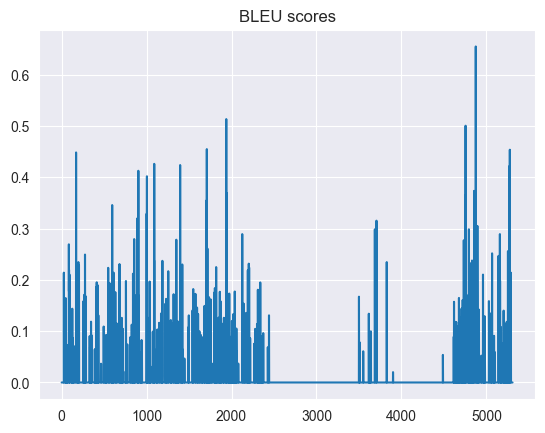

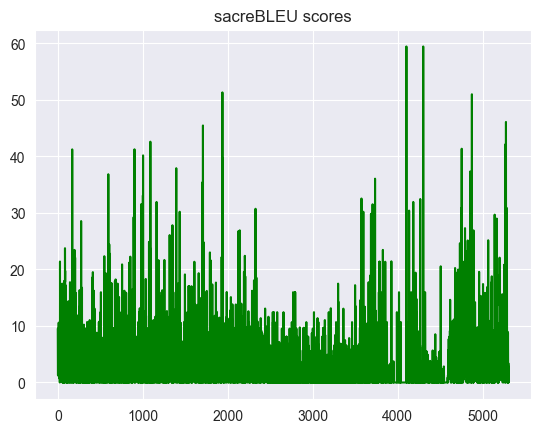

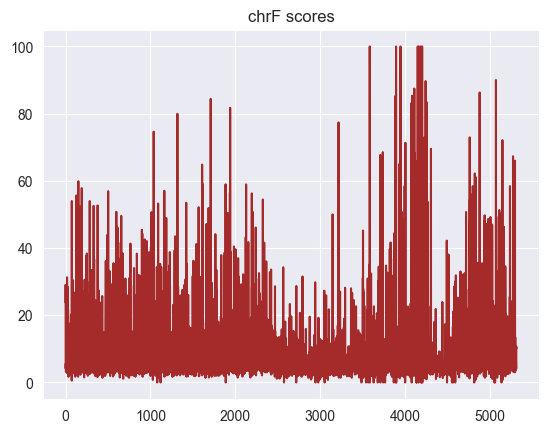

In [25]:
plot_values_by_index('BLEU scores', bleu_classic_scores)
plot_values_by_index('sacreBLEU scores', sacrebleu_scores, color='green')
plot_values_by_index('chrF scores', chrf_scores, color='brown')

Nothing seems to indicate that the missing line is causing problems...

Also, there seems to be considerable agreement between the classic BLEU score and SacreBLEU (except from low scores).